In [ ]:
%%capture
!pip install nfl_data_py

!pip install pandas==2.2.2
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install sklearn
# !pip install xgboost

  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfl-data-py 0.3.3 requires pandas<2.0,>=1.0, but you have pandas 2.2.2 which is incompatible.


In [ ]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

In [ ]:
pbp = nfl.import_pbp_data([2020, 2021, 2022])

2020 done.
2021 done.
2022 done.
Downcasting floats.


In [ ]:
pbp.head()

,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,...,passer,passer_jersey_number,rusher,rusher_jersey_number,receiver,receiver_jersey_number,pass,rush,first_down,special,play,passer_id,rusher_id,receiver_id,name,jersey_number,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,nflverse_game_id,old_game_id_y,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,None,None,None,None,NaN,2020-09-13,900.0,1800.0,3600.0,Half1,0.0,NaN,0.0,1.0,NaN,0,15:00,ARI 35,0.0,NaN,GAME,None,NaN,0.0,0.0,NaN,0.0,0.0,0.0,None,None,NaN,NaN,None,None,None,NaN,None,None,3.0,3.0,NaN,None,...,None,NaN,None,NaN,None,NaN,0.0,0.0,NaN,0.0,0.0,None,None,None,None,NaN,None,None,None,None,None,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020_01_ARI_SF,2020091311,,None,None,NaN,None,NaN,,,,0.0,0.0,NaN,NaN,None,None,None,None
1,39.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,ARI,35.0,2020-09-13,900.0,1800.0,3600.0,Half1,0.0,1.0,0.0,1.0,NaN,0,15:00,ARI 35,0.0,41.0,5-Z.Gonzalez kicks 65 yards from ARI 35 to end...,kickoff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None,None,None,65.0,None,None,3.0,3.0,0.0,None,...,None,NaN,None,NaN,None,NaN,0.0,0.0,0.0,1.0,0.0,None,None,None,None,NaN,None,None,None,None,None,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020_01_ARI_SF,2020091311,ARI,None,None,NaN,None,NaN,45142;46331;46674;45037;46253;44878;42579;4637...,00-0033258;00-0034490;00-0033862;00-0029747;00...,00-0034073;00-0034730;00-0033783;00-0031961;00...,11.0,11.0,NaN,NaN,None,None,None,None
2,54.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,SF,75.0,2020-09-13,900.0,1800.0,3600.0,Half1,0.0,1.0,0.0,1.0,1.0,0,15:00,SF 25,10.0,41.0,(15:00) (Shotgun) 10-J.Garoppolo pass short ri...,pass,5.0,1.0,0.0,1.0,0.0,0.0,0.0,short,right,4.0,1.0,None,None,None,NaN,None,None,3.0,3.0,0.0,None,...,J.Garoppolo,10.0,None,NaN,G.Kittle,85.0,1.0,0.0,1.0,0.0,1.0,00-0031345,None,00-0033288,J.Garoppolo,10.0,00-0031345,G.Kittle,00-0033288,G.Kittle,00-0033288,0.0,1.0,1.294838,0.50337,4.275047,2.0,0.619306,0.239695,0.515058,48.494156,2020_01_ARI_SF,2020091311,SF,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",4.0,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0,4.19,2.436,False,OUT,MAN_COVERAGE,COVER_1
3,93.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,SF,55.0,2020-09-13,882.0,1782.0,3582.0,Half1,0.0,1.0,0.0,1.0,1.0,0,14:42,SF 45,10.0,41.0,(14:42) (Shotgun) 31-R.Mostert right tackle to...,run,14.0,1.0,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,right,tackle,None,NaN,None,None,3.0,3.0,0.0,None,...,None,NaN,R.Mostert,31.0,None,NaN,0.0,1.0,1.0,0.0,1.0,None,00-0031687,None,R.Mostert,31.0,00-0031687,R.Mostert,00-0031687,R.Mostert,00-0031687,0.0,1.0,0.857214,NaN,NaN,NaN,NaN,NaN,0.413357,-41.335732,2020_01_ARI_SF,2020091311,SF,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",NaN,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0,NaN,NaN,None,None,None,

In [ ]:
pbp_clean = pbp[(pbp['pass'] == 1) & (pbp['play_type'] != 'no_play')]
print(pbp.shape)
print(pbp_clean.shape)

(147061, 391)
(64407, 391)


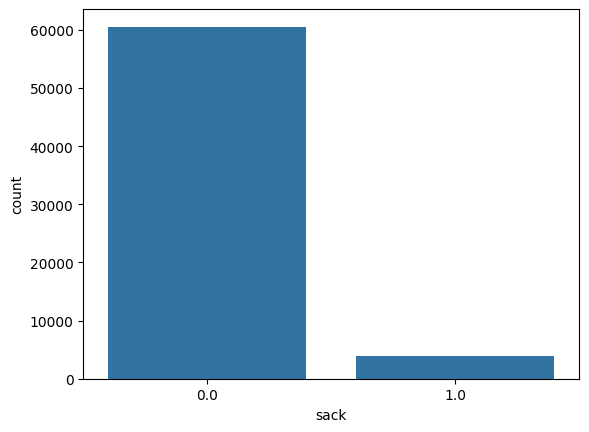

In [ ]:
sns.countplot(x = pbp_clean['sack'])
plt.show()

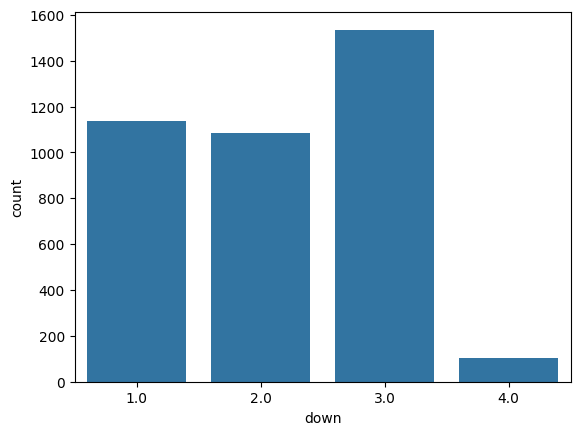

In [ ]:
sacks = pbp_clean[(pbp_clean['sack'] ==  1)]
sns.countplot(x=sacks['down'])
plt.show()

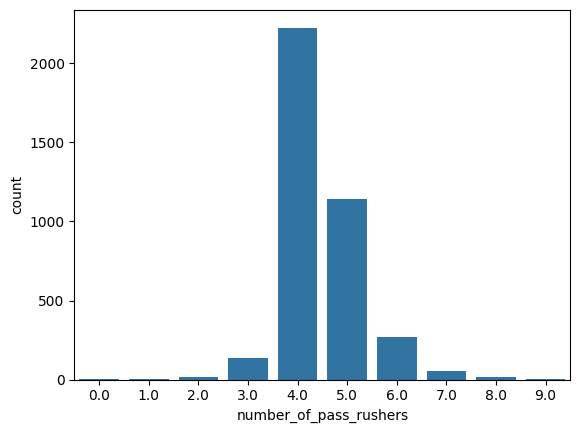

In [ ]:
sns.countplot(x = sacks['number_of_pass_rushers'])
plt.show()

In [ ]:
pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1, 0)

<ipython-input-15-65d86cb3ab37>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1, 0)
<ipython-input-15-65d86cb3ab37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1, 0)


In [ ]:
pbp_clean.head()

,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,...,passer_jersey_number,rusher,rusher_jersey_number,receiver,receiver_jersey_number,pass,rush,first_down,special,play,passer_id,rusher_id,receiver_id,name,jersey_number,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,nflverse_game_id,old_game_id_y,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type,obvious_pass
2,54.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,SF,75.0,2020-09-13,900.0,1800.0,3600.0,Half1,0.0,1.0,0.0,1.0,1.0,0,15:00,SF 25,10.0,41.0,(15:00) (Shotgun) 10-J.Garoppolo pass short ri...,pass,5.0,1.0,0.0,1.0,0.0,0.0,0.0,short,right,4.0,1.0,None,None,None,NaN,None,None,3.0,3.0,0.0,None,...,10.0,None,NaN,G.Kittle,85.0,1.0,0.0,1.0,0.0,1.0,00-0031345,None,00-0033288,J.Garoppolo,10.0,00-0031345,G.Kittle,00-0033288,G.Kittle,00-0033288,0.0,1.0,1.294838,0.503370,4.275047,2.0,0.619306,0.239695,0.515058,48.494156,2020_01_ARI_SF,2020091311,SF,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",4.0,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0,4.19,2.436,False,OUT,MAN_COVERAGE,COVER_1,0
6,165.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,ARI,45.0,2020-09-13,759.0,1659.0,3459.0,Half1,0.0,1.0,0.0,1.0,3.0,0,12:39,ARI 45,14.0,41.0,(12:39) (Shotgun) 10-J.Garoppolo pass short mi...,pass,11.0,1.0,0.0,1.0,0.0,0.0,0.0,short,middle,10.0,1.0,None,None,None,NaN,None,None,3.0,3.0,0.0,None,...,10.0,None,NaN,G.Kittle,85.0,1.0,0.0,0.0,0.0,1.0,00-0031345,None,00-0033288,J.Garoppolo,10.0,00-0031345,G.Kittle,00-0033288,G.Kittle,00-0033288,0.0,1.0,-0.538702,1.054806,4.119796,2.0,0.837606,0.374325,0.971992,2.800822,2020_01_ARI_SF,2020091311,SF,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"1 DL, 5 LB, 5 DB",4.0,46078;38547;45069;46113;38551;41325;45185;4781...,00-0034847;00-0033221;00-0034860;00-0031376;00...,00-0029560;00-0029585;00-0035236;00-0029747;00...,11.0,11.0,9.17,2.201,False,HITCH,ZONE_COVERAGE,COVER_3,1
9,245.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,ARI,away,SF,ARI,75.0,2020-09-13,710.0,1610.0,3410.0,Half1,0.0,2.0,0.0,1.0,1.0,0,11:50,ARI 25,10.0,10.0,(11:50) (Shotgun) 1-K.Murray pass short left t...,pass,3.0,1.0,0.0,1.0,0.0,0.0,0.0,short,left,3.0,0.0,None,None,None,NaN,None,None,3.0,3.0,0.0,None,...,1.0,None,NaN,D.Hopkins,10.0,1.0,0.0,0.0,0.0,1.0,00-0035228,None,00-0030564,K.Murray,1.0,00-0035228,D.Hopkins,00-0030564,D.Hopkins,00-0030564,0.0,1.0,-0.414011,0.715011,4.777031,3.0,0.676852,0.231105,0.442755,55.724480,2020_01_ARI_SF,2020091311,ARI,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"4 DL, 2 LB, 5 DB",4.0,42389;47785;39973;38779;39965;44815;46166;4778...,00-0030564;00-0029316;00-0030585;00-0034785;00...,00-0032057;00-0035717;00-0033870;00-0032164;00...,11.0,11.0,4.08,1.835,False,OUT,ZONE_COVERAGE,COVER_4,0
10,274.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,ARI,away,SF,ARI,72.0,2020-09-13,684.0,1584.0,3384.0,Half1,0.0,2.0,0.0,1.0,2.0,0,11:24,ARI 28,7.0,10.0,"(11:24) (No Huddle, Shotgun) 1-K.Murray pass s...",pass,7.0,1.0,1.0,1.0,0.0,0.0,0.0,short,left,6.0,1.0,None,None,None,NaN,None,None,3.0,3.0,0.0,None,...,1.0,None,Na

In [ ]:
pre_df = pbp_clean[['game_id', 'play_id', 'season', 'name', 'down', 'ydstogo',
                    'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
                    'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]
#pre_df.isna().sum()

df = pre_df.dropna()
df.isna().sum()

,0
game_id,0
play_id,0
season,0
name,0
down,0
ydstogo,0
yardline_100,0
game_seconds_remaining,0
defenders_in_box,0
number_of_pass_rushers,0


In [ ]:
df.head()

,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
2,2020_01_ARI_SF,54.0,2020,J.Garoppolo,1.0,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0
6,2020_01_ARI_SF,165.0,2020,J.Garoppolo,3.0,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0
9,2020_01_ARI_SF,245.0,2020,K.Murray,1.0,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0
10,2020_01_ARI_SF,274.0,2020,K.Murray,2.0,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0
11,2020_01_ARI_SF,298.0,2020,K.Murray,1.0,10.0,65.0,3360.0,6.0,4.0,0.453060,0,0.0


In [ ]:
df['down'] = df['down'].astype('category')
df_no_ids = df.drop(columns = ['game_id', 'play_id', 'name', 'season'])
df_no_ids = pd.get_dummies(df_no_ids, columns =['down'])


<ipython-input-32-5a34d58f933e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['down'] = df['down'].astype('category')


In [ ]:
df_no_ids.head()

,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack,down_1.0,down_2.0,down_3.0,down_4.0
2,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0,True,False,False,False
6,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0,False,False,True,False
9,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0,True,False,False,False
10,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0,False,True,False,False
11,10.0,65.0,3360.0,6.0,4.0,0.453060,0,0.0,True,False,False,False


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
  strat_train_set = df_no_ids.iloc[train_index]
  strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns = ['sack'])
Y_train= strat_train_set['sack']
X_test = strat_test_set.drop(columns = ['sack'])
Y_test = strat_test_set['sack']

In [ ]:
Y_test

,sack
62493,0.0
21246,0.0
97916,0.0
78272,0.0
80252,0.0
...,...
10949,0.0
86818,0.0
96351,0.0
87165,0.0


In [ ]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)
LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns =['no_sack', 'sack'])[['sack']]

print('Brier Score:', brier_score_loss(Y_test, LR_pred))

Brier Score: 0.05685119941067303


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)
RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns = ['no sack', 'sack'])[['sack']]
print('Brier Score:', brier_score_loss(Y_test, RF_pred))

Brier Score: 0.059979799014802035


In [ ]:
XGB = XGBClassifier(objective="binary:logistic", random_state = 42)
XGB.fit(X_train, Y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['no sack', 'sack'])[['sack']]
print('Brier Score:', brier_score_loss(Y_test, XGB_pred))

Brier Score: 0.05740779979803924


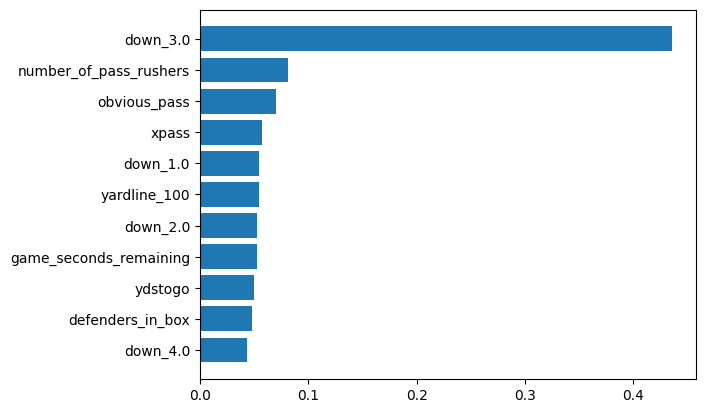

In [ ]:
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.show()

In [ ]:
make_sacks_preds = df_no_ids.drop('sack', axis = 1)
XGB_total_predictions = pd.DataFrame(XGB.predict_proba(make_sacks_preds), columns = ['no_sack', 'sack_pred'])[['sack_pred']]

sacks_preds = df.reset_index().drop(columns = ['index'])
sacks_preds['sack_pred'] = XGB_total_predictions

sacks_preds['sacks_oe'] = sacks_preds['sack'] - sacks_preds['sack_pred']
sacks_preds[(sacks_preds['season'] == 2022)].groupby('name').agg({'sack':'sum', 'sack_pred': 'sum', 'sacks_oe': 'sum'}).reset_index().sort_values('sacks_oe', ascending = True)

,name,sack,sack_pred,sacks_oe
94,T.Brady,24.0,45.028336,-21.028334
51,J.Goff,23.0,38.516624,-15.516623
83,P.Mahomes,29.0,42.094200,-13.094202
100,T.Lawrence,31.0,43.589252,-12.589254
34,D.Prescott,22.0,30.355921,-8.355921
...,...,...,...,...
43,J.Burrow,51.0,42.077057,8.922941
32,D.Jones,52.0,42.162750,9.837249
8,B.Mayfield,36.0,23.971987,12.028014
87,R.Wilson,55.0,37.797665,17.202335


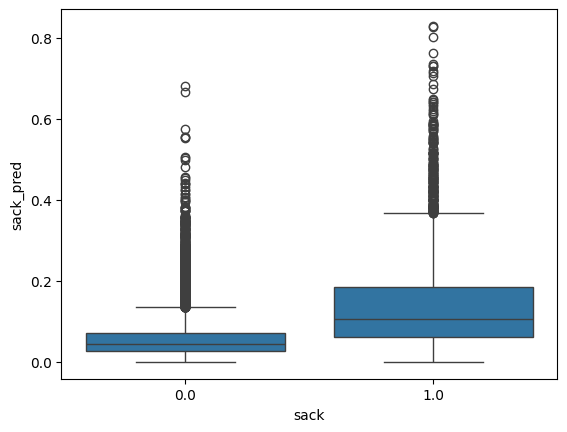

In [ ]:
sns.boxplot(x = sacks_preds['sack'], y = sacks_preds['sack_pred'])
plt.show()